In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
import rsa

## Encoding and Decoding Functions

In [23]:
def audio_from_wav(filename, save_mono=False):
    fs, data = wavfile.read(filename)
    audio = (data[:,0] + data[:,1]) // 2
    if (save_mono):
        data[:,0] = audio
        data[:,1] = audio
        filename = filename.split('.')[0] + '_mono.wav'
        wavfile.write(filename, fs, data)
    return fs, audio

def audio_to_wav(audio, filename, fs, N_original):
    data = np.zeros((N_original, 2)).astype(np.int16)
    data[:,0] = audio[0:N_original]
    data[:,1] = audio[0:N_original]
    wavfile.write(filename, fs, data)

def pad_audio(audio, fs, df):
    N = len(audio)
    N_min = fs/df
    N_req = int((N // N_min + 1) * N_min - N)
    pad = np.linspace(0, 0, N_req)
    audio = np.concatenate((audio, pad))
    return audio

def remove_low_frequencies(audio, fs, f_max):
    audio_fft = np.fft.rfft(audio)
    audio_fft[0:len(audio)*f_max//fs] = 0
    audio = np.real(np.fft.irfft(audio_fft))
    return audio

def add_data(audio, data, ampl, fs, df, f_min):
    f_min = max(f_min, df)
    
    f_data = np.linspace(f_min, f_min + (len(data)-1) * df, len(data))
    f_audio = np.fft.rfftfreq(len(audio), 1/fs)
    audio_fft = np.fft.rfft(audio)

    f_d = 0
    for f in range(len(f_audio)):
        if (f_data[f_d] <= f_audio[f]):
            audio_fft[f] = ampl * data[f_d]
            f_d += 1
            if f_d == len(f_data):
                break

    audio = np.real(np.fft.irfft(audio_fft))
    return audio

def recover_data(audio, data_ampl, data_len, fs, df, f_min):
    data = np.zeros(data_len)

    f_data = np.linspace(f_min, f_min + (len(data)-1) * df, len(data))
    f_audio = np.fft.rfftfreq(len(audio), 1/fs)
    audio_fft = np.fft.rfft(audio)

    f_d = 0
    for f in range(len(f_audio)):
        if (f_data[f_d] <= f_audio[f]):
            if (np.real(audio_fft[f]) > data_ampl/2):
                data[f_d] = 1
            f_d += 1
            if f_d == len(f_data):
                break
    return data

## Encryption Functions

In [24]:
def create_keys(length, filename):
    public_key, private_key = rsa.newkeys(length)

    with open('/'.join(filename.split('/')[0:-1]) + '/public_key.pem', 'wb') as f:
        f.write(public_key.save_pkcs1())
    
    with open('/'.join(filename.split('/')[0:-1]) + '/private_key.pem', 'wb') as f:
        f.write(private_key.save_pkcs1())
        
    return public_key, private_key


def read_public_key(filename):
    with open('/'.join(filename.split('/')[0:-1]) + '/public_key.pem', 'rb') as f:
        public_key = rsa.PublicKey.load_pkcs1(f.read())
   
    return public_key


def read_private_key(filename):
    with open('/'.join(filename.split('/')[0:-1]) + '/private_key.pem', 'rb') as f:
        private_key = rsa.PrivateKey.load_pkcs1(f.read())

    return private_key




def encrypt_data(message, private_key):
    return rsa.sign(message.encode(), private_key, 'SHA-1')

def check_data(message, sign_message , public_key):
    try:
        rsa.verify(message.encode(), sign_message, public_key)
        return True
    except:
        return False
    

def extract_audio_signature(audio_name):
    fs, audio = audio_from_wav(audio_name)
    df = 1
    audio = pad_audio(audio, fs, df)
    audio_fft = np.abs(np.fft.rfft(audio))
    f = np.fft.rfftfreq(len(audio), 1/fs)

    # start inputs
    section_width = 10
    f_start = 200
    f_end = 600
    section_count = (f_end-f_start)//section_width

    # section off the audio
    sections = [[ ] for _ in range(section_count)]
    for s in range(len(sections)):
        section_start = f_start + s * section_width
        section_end = section_start + section_width
        section_indices = np.where((f >= section_start) & (f < section_end))[0]
        sections[s] = audio_fft[section_indices]

    sections = np.array(sections)
    averages = [np.average(arr) for arr in sections]
    byte_averages = [np.average(averages[i:i+8]) for i in range(0, len(averages), 8)]
    output = np.array([(averages[i] > byte_averages[i//8]).astype(int) for i in range(len(averages))])

    print(''.join(str(bit) for bit in output))
    return output


def convert_bit_array_to_string(bit_array):
    binary_string = ''.join(str(bit) for bit in bit_array)
    ascii_chars = ["0" + binary_string[i+1:i+8] for i in range(0, len(binary_string), 8)]
    string = ''.join(chr(int(char, 2)) for char in ascii_chars)
    print(string)
    return string

def bytes_to_binary(bytes_obj):
    return ''.join(format(byte, '08b') for byte in bytes_obj)

def binary_to_bytes(binary_str):
    return bytes(int(binary_str[i:i+8], 2) for i in range(0, len(binary_str), 8))


def get_data(audio_name,private_key):
    message = convert_bit_array_to_string(extract_audio_signature(audio_name))

    sign_message = encrypt_data(message, private_key)
    bin_sign_message=bytes_to_binary(sign_message)    
    bin_data = [int(bit) for bit in bin_sign_message]
    return bin_data


def check_watermark(audio_name, bin_data_array , public_key):
    message = convert_bit_array_to_string(extract_audio_signature(audio_name))
    bin_data = ''.join(str(bit) for bit in bin_data_array)
    sign_message = binary_to_bytes(bin_data)
    return check_data(message, sign_message, public_key)

SyntaxError: invalid syntax (599473286.py, line 67)

## Helper Functions

In [ ]:
def plot_fft(audio, fs, f_max = 250):
    f_full = np.fft.rfftfreq(len(audio), 1/fs)
    audio_fft = np.fft.rfft(audio)
    plt.figure()
    plt.plot(f_full, np.abs(audio_fft))
    plt.xlim([0, f_max])
    plt.ylim([0, 1.5e7])
    plt.title('Song fft')

## Implentation

In [ ]:
DELTA_FREQUENCIES = 0.2 # Hz
LOWEST_FREQUENCY = 1 # Hz
DATA_LENGTH = 368
BINARY_AMPLITUDES = 1e7

def encrypt_audio(filename):
    # Keys and data
    public_key, private_key = create_keys(365, filename);
    data = get_data(filename, private_key)
    # Audio from file
    fs, audio = audio_from_wav(filename, True)
    N_original = len(audio)
    # plot_fft(audio, fs)

    # Add data to audio
    audio = pad_audio(audio, fs, DELTA_FREQUENCIES)
    audio = remove_low_frequencies(audio, fs, 100)
    # plot_fft(audio, fs)
    audio = add_data(audio, data, BINARY_AMPLITUDES, fs, DELTA_FREQUENCIES, LOWEST_FREQUENCY)
    # plot_fft(audio, fs)
    plot_fft(audio, fs)

    # Save audio to file
    audio_to_wav(audio, filename.split('.')[0] + '_with_data.wav', fs, N_original)
    return public_key, private_key

    

def check_audio(filename, public_key):
    fs, audio = audio_from_wav(filename)
    audio = pad_audio(audio, fs, DELTA_FREQUENCIES)
    plot_fft(audio, fs)
    plot_fft(audio, fs, 10)

    data_r = recover_data(audio, BINARY_AMPLITUDES, DATA_LENGTH, fs, DELTA_FREQUENCIES, LOWEST_FREQUENCY).astype(int)

    check = check_watermark(filename,data_r,public_key)
    return check


In [ ]:
def manipulate_file(filename):
    encrypt_audio(filename)
    public_key = read_public_key(filename)
    print(check_audio(filename.split('.')[0] + '_with_data.wav', public_key))

/var/folders/rj/9n9dpytj2n74_jwlj_p0xk9m0000gn/T/ipykernel_27439/206914725.py:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, data = wavfile.read(filename)
/var/folders/rj/9n9dpytj2n74_jwlj_p0xk9m0000gn/T/ipykernel_27439/206914725.py:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, data = wavfile.read(filename)


False


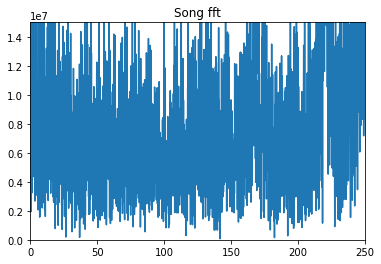

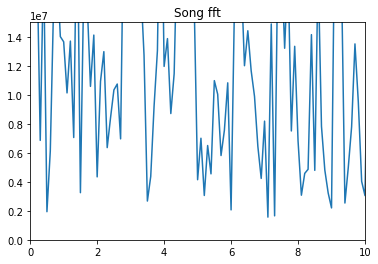

In [ ]:
# manipulate_file('AudioFiles/BB/BB_small.wav')
# manipulate_file('AudioFiles/CR1/CR_small.wav')
# manipulate_file('AudioFiles/CR2/CR_small.wav')
# manipulate_file('AudioFiles/DT1/DT_small.wav')
# manipulate_file('AudioFiles/DT2/DT_small.wav')
filename = 'AudioFiles/BB/BB_rr.wav'
public_key = read_public_key(filename)
print(check_audio(filename, public_key))